In [1]:
from utils import *
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, MaxPooling2D, Concatenate, Input, GlobalAveragePooling2D, Dropout, Subtract, Lambda
from keras import Model
import os

Using TensorFlow backend.


In [2]:
inception_model =  keras.applications.InceptionV3(include_top=False,
    weights="imagenet",
    input_shape= (224, 224, 3))
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [3]:
densor1 = Dense(128, activation = 'relu')

for layer in inception_model.layers:
    layer.trainable = False
    
last_layer = inception_model.get_layer('mixed9')
last_output = last_layer.output
x = GlobalAveragePooling2D()(last_output)
x = Dropout(0.2)(x)
x = densor1(x)


pretrained_model = Model(inputs = inception_model.input, outputs = x)
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [4]:
def full_model():
    input_A = Input(shape = (224, 224, 3))
    input_B = Input(shape = (224, 224, 3))
    
    A_x = pretrained_model(input_A)
    B_x = pretrained_model(input_B)
    
    x = Subtract()([A_x, B_x])
    x = Lambda(lambda y:abs(y))(x)
    x = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = [input_A, input_B], outputs = x)
    return model
    

In [5]:
model = full_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          15984992    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 128)          0           model_1[1][0]              

In [6]:
inputA, inputB, y = load_data(r'C:\Users\Dev\Desktop\Ongoing_projects\Face_Recognition\Data\pairsDevTrain.txt')
print(inputA.shape)
print(inputB.shape)
print(y.shape)

from random import shuffle

ind_list = [i for i in range(inputA.shape[0])]
shuffle(ind_list)
inputA  = inputA[ind_list, :,:,:]
inputB = inputB[ind_list, :,:,:]
y = y[ind_list, :]
inputA = inputA/255
inputB = inputB/255

(2200, 224, 224, 3)
(2200, 224, 224, 3)
(2200, 1)


In [7]:
root_logdir = os.path.join(os.curdir, 'my_logs')
def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [8]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model2.h5",save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 100,restore_best_weights= True)

In [9]:
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=[ tf.keras.metrics.BinaryAccuracy()])

In [10]:
history = model.fit(x = [inputA, inputB], y = y, epochs = 150, callbacks = [checkpoint_cb], validation_split = 0.1)

Train on 1980 samples, validate on 220 samples
Epoch 1/150
1980/1980 [==============================] - 65s 33ms/step - loss: 0.6980 - binary_accuracy: 0.4965 - val_loss: 0.6905 - val_binary_accuracy: 0.5106
Epoch 2/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.6536 - binary_accuracy: 0.5639 - val_loss: 0.6866 - val_binary_accuracy: 0.5907
Epoch 3/150
1980/1980 [==============================] - 38s 19ms/step - loss: 0.6025 - binary_accuracy: 0.6222 - val_loss: 0.6813 - val_binary_accuracy: 0.6380
Epoch 4/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.5340 - binary_accuracy: 0.6620 - val_loss: 0.6735 - val_binary_accuracy: 0.6808
Epoch 5/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.4476 - binary_accuracy: 0.7019 - val_loss: 0.6685 - val_binary_accuracy: 0.7169
Epoch 6/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.3739 - binary_accuracy: 0.7334 - val_loss: 0.6654 - val_binary_accu

1980/1980 [==============================] - 40s 20ms/step - loss: 0.0092 - binary_accuracy: 0.9341 - val_loss: 0.9418 - val_binary_accuracy: 0.9343
Epoch 52/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.0079 - binary_accuracy: 0.9347 - val_loss: 0.9644 - val_binary_accuracy: 0.9349
Epoch 53/150
1980/1980 [==============================] - 40s 20ms/step - loss: 0.0071 - binary_accuracy: 0.9352 - val_loss: 0.9508 - val_binary_accuracy: 0.9354
Epoch 54/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.0104 - binary_accuracy: 0.9357 - val_loss: 0.9783 - val_binary_accuracy: 0.9358
Epoch 55/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.0089 - binary_accuracy: 0.9362 - val_loss: 0.9673 - val_binary_accuracy: 0.9363
Epoch 56/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.0075 - binary_accuracy: 0.9366 - val_loss: 0.9845 - val_binary_accuracy: 0.9368
Epoch 57/150
1980/1980 [=================

1980/1980 [==============================] - 39s 20ms/step - loss: 0.0047 - binary_accuracy: 0.9469 - val_loss: 1.3096 - val_binary_accuracy: 0.9469
Epoch 102/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.0089 - binary_accuracy: 0.9470 - val_loss: 1.2349 - val_binary_accuracy: 0.9470
Epoch 103/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.0089 - binary_accuracy: 0.9471 - val_loss: 1.2293 - val_binary_accuracy: 0.9471
Epoch 104/150
1980/1980 [==============================] - 40s 20ms/step - loss: 0.0048 - binary_accuracy: 0.9472 - val_loss: 1.3000 - val_binary_accuracy: 0.9472
Epoch 105/150
1980/1980 [==============================] - 39s 20ms/step - loss: 0.0046 - binary_accuracy: 0.9473 - val_loss: 1.2496 - val_binary_accuracy: 0.9474
Epoch 106/150
1980/1980 [==============================] - 40s 20ms/step - loss: 0.0062 - binary_accuracy: 0.9475 - val_loss: 1.2901 - val_binary_accuracy: 0.9475
Epoch 107/150
1980/1980 [===========

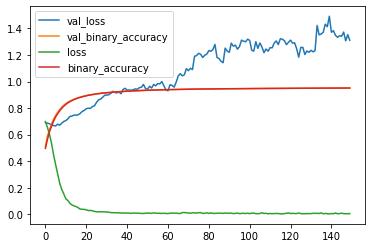

In [11]:
import pandas as pd
def plot_history(history):
    pd.DataFrame(history.history).plot()
    
plot_history(history)

In [12]:
inputA, inputB, y = load_data(r'C:\Users\Dev\Desktop\Ongoing_projects\Face_Recognition\Data\pairsDevTest.txt')
print(inputA.shape)
print(inputB.shape)
print(y.shape)

(1000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 1)


In [13]:
model.evaluate(x = [inputA, inputB], y = y)

1000/1000 [==============================] - 19s 19ms/step


[57.265838256835934, 0.9502257108688354]

In [14]:
model.save('model.h5')